In [135]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from torchvision import models
from pytorch_h5dataset.dataset.imageDataset import ImageDataset
file_name = "CHECKPOINTNAME"

from torchvision import transforms
from torch import nn
import torchvision

In [136]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torch.optim import SGD, Adam
def default(val, def_val):
    return def_val if val is None else val

class AddProjection(nn.Module):
    def __init__(self, embedding_size, model=None, mlp_dim=512):
        super(AddProjection, self).__init__()
        embedding_size = embedding_size
        self.backbone = default(model, models.resnet18(pretrained=False, num_classes=embedding_size))
        mlp_dim = default(mlp_dim, self.backbone.fc.in_features)
        print('Dim MLP input:',mlp_dim)
        self.backbone.fc = nn.Identity()

        # add mlp projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features=mlp_dim, out_features=mlp_dim),
            nn.BatchNorm1d(mlp_dim),
            nn.ReLU(),
            nn.Linear(in_features=mlp_dim, out_features=embedding_size),
            nn.BatchNorm1d(embedding_size),
        )

    def forward(self, x, return_embedding=False):
        embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.projection(embedding)



def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups


class SimCLR_pl(pl.LightningModule):
    def __init__(self,embedding_size, model=None, feat_dim=512):
        super().__init__()
        
        self.model = AddProjection(embedding_size, model=model, mlp_dim=feat_dim)

    def forward(self, X):
        return self.model(X)



In [69]:
m = torchvision.models.get_model("resnet50", num_classes=5)
model = SimCLR_pl(128, model=m, feat_dim=2048)
model = model.model.backbone

/opt/conda/envs/ml_poldiv_py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/ml_poldiv_py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Dim MLP input: 2048


In [71]:
import torchvision.transforms as transforms
from zipdataset import ImageZipDataset
import torchvision.transforms as T
from torch.utils.data import DataLoader
import pandas as pd
def load_pickle(name, delimiter):
            return pd.read_pickle(name[:-4]+'.pkl')

transforms = T.Compose([
            T.RandomResizedCrop(size=224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

dataset =  ImageZipDataset("../IMAGES_final.zip", "../meta.pkl",
                                transform=transforms,
                                load_fn=load_pickle,
                                split='train',
                                l_key="species_idx",
                                f_key="FilePath",
                                eval_proportion=0.00)

            
data_loader = DataLoader(dataset=dataset,
             pin_memory=True, 
             batch_size=28, 
             num_workers= 64,
             shuffle=False,
             sampler=None,
             drop_last=False)

yy = []
ims = []
labels=[]
families=[]
indices=[]
from tqdm import tqdm
model = model.cuda()
s_idx = []
for im, label in tqdm(data_loader):
    s_idx.extend(list(range(len(s_idx),len(s_idx)+len(label))))
    im=im.cuda()
    y = model(im)
    yy.extend([__y.cpu() for __y in y.detach().cpu()])
    ims.extend([__y.cpu() for __y in im.detach().cpu()])
    labels.extend([__y.cpu() for __y in label.detach().cpu()])
    #families.append(meta['family_idx'].values)
    #indices.append(meta['Index'].values)

number classes 4325


100%|██████████| 2568/2568 [04:32<00:00,  9.43it/s]


In [72]:
len(yy), len(set(s_idx))

(71888, 71888)

In [73]:
families = data_loader.dataset.metadata['family_idx'].iloc[s_idx]
genus = data_loader.dataset.metadata['genus_idx'].iloc[s_idx]
subclass = data_loader.dataset.metadata['subclass_idx'].iloc[s_idx]
order = data_loader.dataset.metadata['order_idx'].iloc[s_idx]
indices = data_loader.dataset.metadata['Index'].iloc[s_idx]

In [74]:
import pickle as pkl
pkl.dump({'features':yy, 'target':labels, 'indices': indices, 'families':families}, open('dataset_v4.pkl','wb'))

In [75]:
len(yy)

71888

In [76]:
meta = data_loader.dataset.metadata.iloc[dataset.indices]

In [77]:
meta

,Unnamed: 0.1,Unnamed: 0,family,genus,species,filename,ansicht,order,subclass,species_name,family_idx,genus_idx,species_idx,ansicht_idx,order_idx,subclass_idx,Index,FilePath,ClassNo,FileType
52822,69083,70837,Veneridae,Leukoma,Leukomastaminea,Veneridae_Leukoma_staminea_iDigBio_001-002.jpg,aussen,Venerida,Imparidentia,staminea,47,483,2113,0,26,2,70837,IMAGES_final/Veneridae_Leukoma_staminea_iDigBi...,2113,image
6039,27127,27586,Lucinidae,Lucinella,Lucinelladivaricata,Lucinidae_Lucinella_divaricata_Poppe_835995-00...,aussen,Lucinida,Imparidentia,divaricata,26,508,2270,0,12,2,27586,IMAGES_final/Lucinidae_Lucinella_divaricata_Po...,2270,image
13034,41161,42764,Pectinidae,Argopecten,Argopectengibbus,Pectinidae_Argopecten_gibbus_GBIF_6-001.jpg,aussen,Pectinida,Pteriomorphia,gibbus,23,67,360,0,20,5,42764,IMAGES_final/Pectinidae_Argopecten_gibbus_GBIF...,360,image
9770,2686,2757,Arcidae,Arca,Arcaventricosa,Arcidae_Arca_ventricosa_Poppe_126975-001.jpg,aussen,Arcida,Pteriomorphia,ventricosa,14,54,319,0,1,5,2757,IMAGES_final/Arcidae_Arca_ventricosa_Poppe_126...,319,image
55495,66568,68322,Veneridae,Antigona,Antigonalamellaris,Veneridae_Antigona_lamellaris_SEQshells_2-001.jpg,innen,Venerida,Imparidentia,lamellaris,47,49,294,1,26,2,68322,IMAGES_final/Veneridae_Antigona_lamellaris_SEQ...,294,image
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3783,7993,8137,Cardiidae,Frigidocardium,Frigidocardiumsancticaroli,Cardiidae_Frigidocardium_sancticaroli_Poppe_17...,aussen,Cardiida,Imparidentia,sancticaroli,55,338,1553,0,2,2,8137,IMAGES_final/Cardiidae_Frigidocardium_sanctica...,1553,image
48490,5630,5774,Cardiidae,Acanthocardia,Acanthocardiaaculeata,Cardiidae_Acanthocardia_aculeata_Wales_003.jpg,aussen,Cardiida,Imparidentia,aculeata,55,2,24,0,2,2,5774,IMAGES_final/Cardiidae_Acanthocardia_aculeata_...,24,image
17094,45445,47048,Pectinidae,Mimachlamys,Mimachlamysgloriosa,Pectinidae_Mimachlamys_gloriosa_shellspassion_...,aussen,Pectinida,Pteriomorphia,gloriosa,23,566,2561,0,20,5,47048,IMAGES_final/Pectinidae_Mimachlamys_gloriosa_s...,2561,image
12981,71435,73576,Yoldiidae,Yoldia,Yoldiaaeolica,Yoldiidae_Yoldia_aeolica_Poppe_112083-001.jpg,aussen,Nuculanida,Protobranchia,aeolica,2,941,4259,0,16,4,73576,IMAGES_final/Yoldiidae_Yoldia_aeolica_Poppe_11...,4259,image


In [78]:
len(set(meta.Index))

71888

In [79]:
data = []
for index, features, target in zip(s_idx,yy, labels):
    d = data_loader.dataset.metadata[data_loader.dataset.metadata.Index==index]
    data.append(
        dict(
            species_t = target.item(),
            species = meta.species_idx.iloc[index],
            genus = meta.genus_idx.iloc[index],
            family = meta.family_idx.iloc[index],
            order = meta.order_idx.iloc[index],
            subclass = meta.subclass_idx.iloc[index],
            features = features.detach().cpu().numpy(),
            index = index,
            orig_index = meta['Index'].iloc[index]
        )
    )

In [80]:
data2 = pd.DataFrame(data)
data2.to_pickle('dataset_v4_meta.pkl')

In [81]:
assert(all(data2.species_t == data2.species))

In [82]:
data2['target'] = data2.species_t

In [83]:
_data2 = data2
_data2 = pd.DataFrame(_data2)


In [84]:
centroids2 = np.zeros((78+1,2048 ), dtype=np.float32)
_data2 = pd.DataFrame(data2)
for fam_idx in range(79):
    _dat = _data2[_data2['family']==fam_idx]['features'].values    
    if len(_dat)==0:
        print(f"Skipping {fam_idx}")
        continue
    _dat = torch.stack([torch.as_tensor(np.array(d, dtype=np.float64)) for d in _dat])
    centroids2[fam_idx,:] = np.median(_dat, axis=0)

Skipping 54
Skipping 74
Skipping 75
Skipping 76
Skipping 77


In [86]:
sfeats = torch.tensor(data2['features'])
sinds =data2['index']
slabs = data2['target']
sfams =data2['family']

In [87]:
fam_index_selector = list(set(list([int(a) for a in sfams])))

In [88]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap, TSNE
skip = 1000
embedding = TSNE(learning_rate='auto', init='pca',n_components=2)
#embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(centroids2[fam_index_selector])

In [89]:
max(X_transformed[:,1])-min(X_transformed[:,1])

11.37433

In [90]:
len(X_transformed[:,1])

74

In [91]:
X_transformed.shape, (max(X_transformed[:,1])-min(X_transformed[:,1]))/(len(X_transformed[:,1]))

((74, 2), 0.15370715631021037)

In [92]:
features, labels, indices, families = data2['features'], data2['target'], data2['index'], data2['family']
all_samples = pd.read_csv('../../meta/Muschelbilder_Daten.csv')
unique_families = all_samples.groupby('family').sample(1)
_label = np.array(families)
features = np.concatenate(features)
centers = torch.zeros((256,78+1), dtype=torch.float64)
centers = np.median(features, axis=0)

df = pd.DataFrame(columns=['features','family_idx','Index'])
data = torch.zeros((58148//79,256,79), dtype=torch.float64)
data = []
for idx,(feature, lidx) in tqdm(enumerate(zip(features, _label))):
    data.append(dict(zip(['features','family_idx','Index'],[feature, lidx,idx])))
data = pd.DataFrame(data)
centroids = np.zeros((78+1,256), dtype=np.float32)
for fam_idx in range(79):
    _dat = data[data['family_idx']==fam_idx]['features'].values    
    try:
        centroids[fam_idx,:] = np.median(np.stack(_dat), axis=0)
        #print(np.median(np.stack(_dat), axis=0))
    except:
        print(fam_idx)

71888it [00:00, 522576.08it/s]


54
74
75
76
77


In [93]:
edge_lengths = pd.read_csv('edge_lengths_corr_names.csv')
print(len(edge_lengths))
edge_lengths
wrong_labels = edge_lengths.family.values
wrong_labels_map = dict(((l,i) for l,i in zip(wrong_labels, range(len(wrong_labels)))))

correct_labels = open('Familien1.csv','r').read().split('\n')[:-1]
wrong_label_locs = dict(((i,l) for l,i in zip(range(len(wrong_labels)),wrong_labels)))
true_label_locs = []
for l in correct_labels:
    true_label_locs.append(wrong_labels_map[l])
    
set(true_label_locs)==set(list(range(len(true_label_locs))))

from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances
selection = np.setdiff1d(np.array(range(79)), np.array([54,74,75,76,77]))
#distances = pairwise_distances(centroids[selection])
distances = pairwise_distances(centroids2[true_label_locs])
print(distances.min(), distances.max())
normed_distances = distances/distances.max()
print(normed_distances, distances)
len(true_label_locs), len(selection)

correct_labels = open('Familien1.csv','r').read().split('\n')[:-1]
wrong_label_locs = dict(((i,l) for l,i in zip(range(len(wrong_labels)),wrong_labels)))
true_label_locs = []
for l in correct_labels:
    true_label_locs.append(wrong_labels_map[l])
    
set(true_label_locs)==set(list(range(len(true_label_locs))))

names = edge_lengths.columns[1:][true_label_locs]
taxon_list = []
for i,family in enumerate(names):
    
    if family == 'Sphaeriidae':        
        continue
    l = [i]
    #print(family)
    l.extend(unique_families[unique_families.family==family][['family', 'order', 'subclass']].values[0])
    taxon_list.append(l)
    #print(i, unique_families[unique_families.family==family][['family', 'order', 'subclass']].values[0])

79
0.0 32.86352
[[0.         0.04821132 0.04737546 ... 0.04912504 0.1030769  0.04687373]
 [0.04821132 0.         0.04570979 ... 0.07779408 0.10675117 0.04092169]
 [0.04737546 0.04570979 0.         ... 0.08361345 0.09706481 0.0470807 ]
 ...
 [0.04912504 0.07779408 0.08361345 ... 0.         0.1354119  0.08216502]
 [0.1030769  0.10675117 0.09706481 ... 0.1354119  0.         0.09850126]
 [0.04687373 0.04092169 0.0470807  ... 0.08216502 0.09850126 0.        ]] [[0.        1.5843936 1.5569246 ... 1.6144218 3.3874698 1.5404359]
 [1.5843936 0.        1.5021847 ... 2.5565875 3.5082192 1.3448309]
 [1.5569246 1.5021847 0.        ... 2.7478323 3.1898913 1.5472378]
 ...
 [1.6144218 2.5565875 2.7478323 ... 0.        4.450112  2.7002318]
 [3.3874698 3.5082192 3.1898913 ... 4.450112  0.        3.2370982]
 [1.5404359 1.3448309 1.5472378 ... 2.7002318 3.2370982 0.       ]]


[(24, -0.15490931, -6.507484), (10, -0.32900968, -6.368772), (42, -0.49439213, -6.2191925), (8, -0.6264924, -6.0949264), (7, -0.94264215, -5.7496433), (23, -0.99560565, -5.6670127), (21, -1.2903602, -5.0456448), (11, -1.279653, -4.9326396), (13, -1.3653666, -4.8619337), (6, -1.3045783, -4.7531233), (25, -1.4485229, -4.437367), (72, -1.1653533, -4.3689985), (61, -1.7692276, -4.2450175), (14, -1.1521626, -4.0480294), (69, -1.2835648, -3.8158998), (18, -1.0118793, -3.8115752), (45, -1.6240269, -3.7718844), (54, -1.1713861, -3.7383296), (17, -1.1191865, -3.471751), (19, -1.0580015, -3.1375237), (39, -1.0420594, -2.817537), (26, -0.455368, -2.0603592), (47, -0.8069812, -1.8838342), (70, -1.0537504, -1.87891), (36, -0.5803924, -1.8595246), (71, -1.0378487, -1.7462829), (15, -0.79404485, -1.5538878), (62, 0.066030964, -1.5193905), (63, -0.05110405, -1.2494671), (12, -1.2694976, -1.1574862), (49, -0.49543843, -0.91494083), (57, -0.30293542, -0.8913598), (68, -0.013780996, -0.82928276), (20, -1

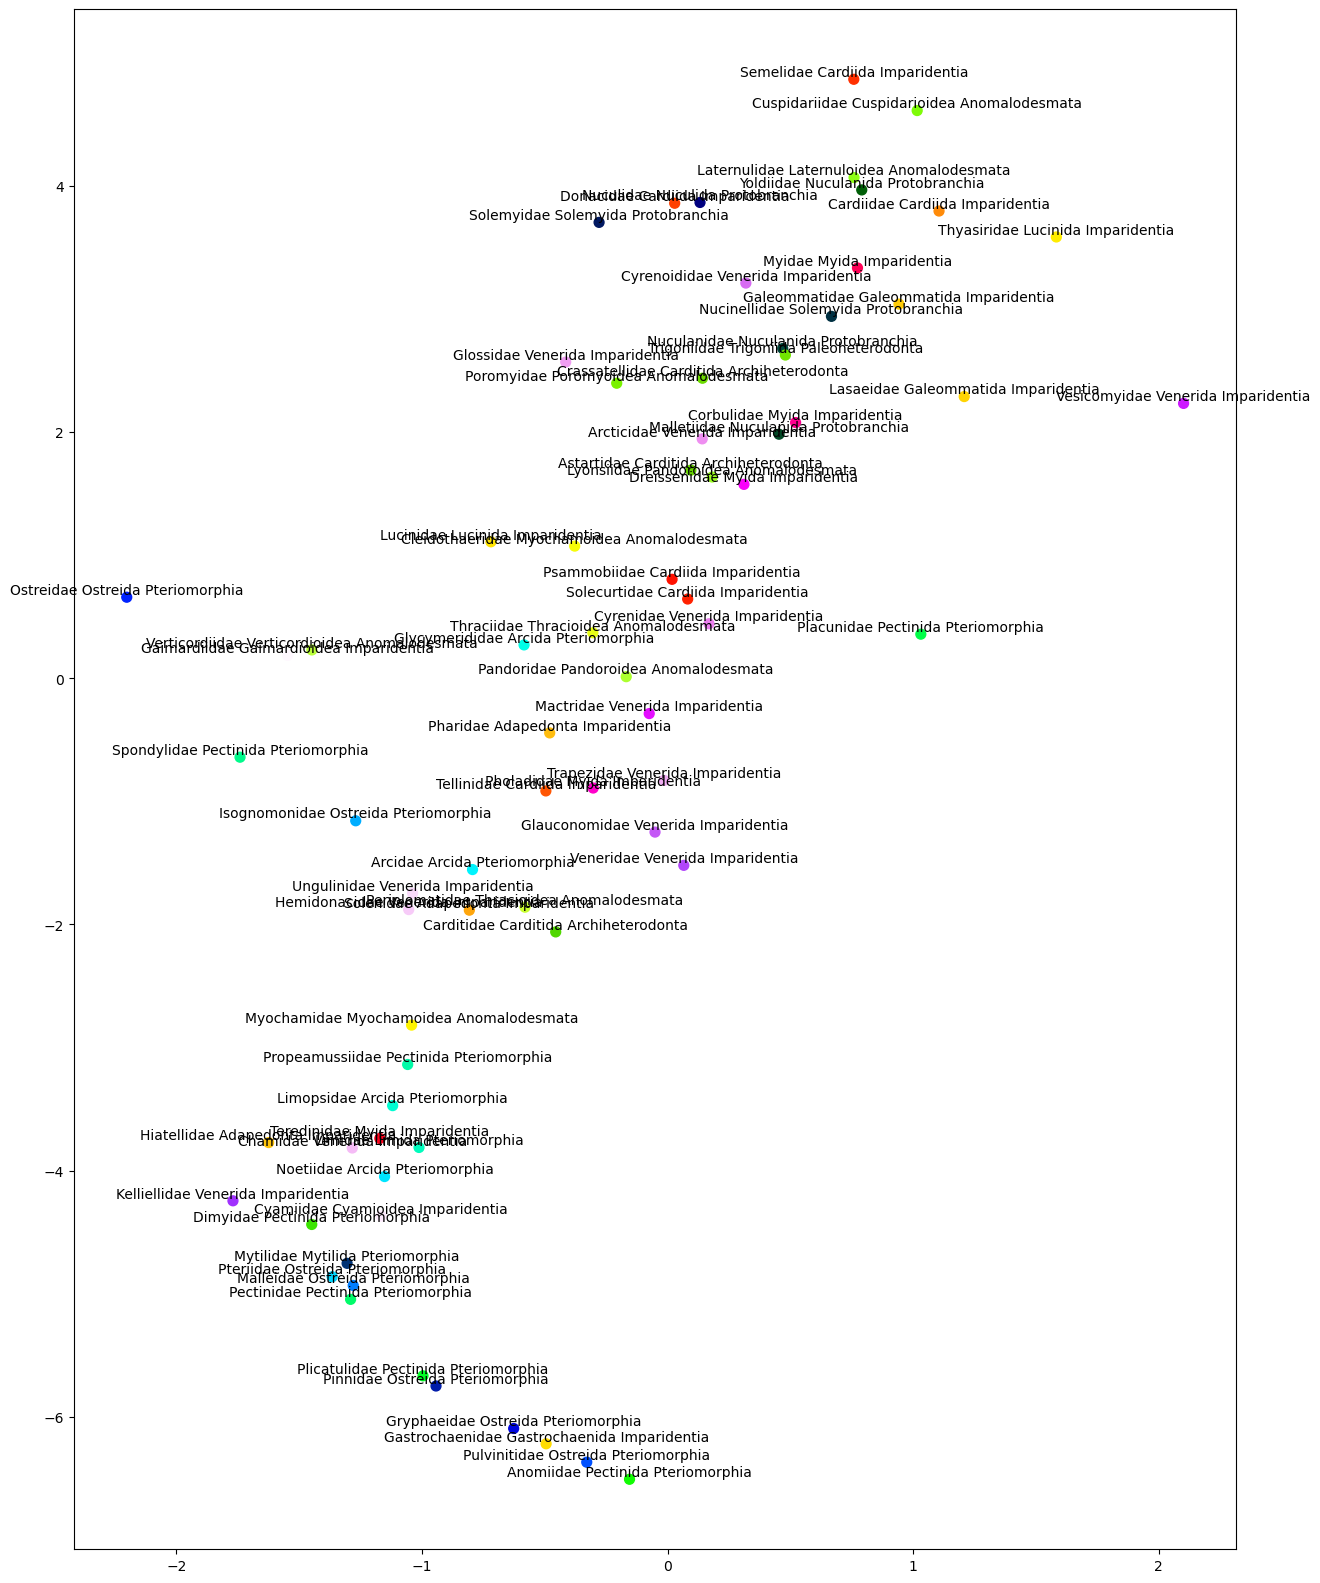

In [96]:
plt.figure(figsize=(15,20))
#x_cent = embedding.transform(centroids2)[list(set(sfams)),:]

#plt.scatter(x_cent[:,0],x_cent[:,1], c=list(set(sfams)),cmap=plt.cm.get_cmap('gist_ncar', 79), s=150) # cubehelix
plt.scatter(X_transformed[:,0],X_transformed[:,1], c=[a for a, _, _, _  in taxon_list],cmap=plt.cm.get_cmap('gist_ncar', 79),s=50)

slots = np.arange(min(X_transformed[:,1]),max(X_transformed[:,1]),(max(X_transformed[:,1])-min(X_transformed[:,1]))/74)
sort_X = sorted(zip(range(len(X_transformed[:,1])),X_transformed[:,0],X_transformed[:,1]),key=lambda x: x[2])
print(sort_X)
print(slots, len(slots))
for i, ((x,y),) in enumerate(zip(X_transformed)):
    plt.text(x,y," ".join(taxon_list[i][1:]), ha="center", va="bottom")


In [97]:
sfeats = torch.cat(yy[:len(yy)-1])
sinds =np.array(indices)
slabs = np.array(labels[:len(labels)-1])
sfams = np.array(families[:len(families)-1])

In [98]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap, TSNE
skip = 1000
#embedding = TSNE(learning_rate='auto', init='pca',n_components=2)
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(centroids2[fam_index_selector])

In [99]:
centroids

array([[0.8636999 , 0.8636999 , 0.8636999 , ..., 0.8636999 , 0.8636999 ,
        0.8636999 ],
       [0.83153874, 0.83153874, 0.83153874, ..., 0.83153874, 0.83153874,
        0.83153874],
       [0.8493131 , 0.8493131 , 0.8493131 , ..., 0.8493131 , 0.8493131 ,
        0.8493131 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9231197 , 0.9231197 , 0.9231197 , ..., 0.9231197 , 0.9231197 ,
        0.9231197 ]], dtype=float32)

In [100]:
len(set([a for a, _, _, _  in taxon_list]))

74

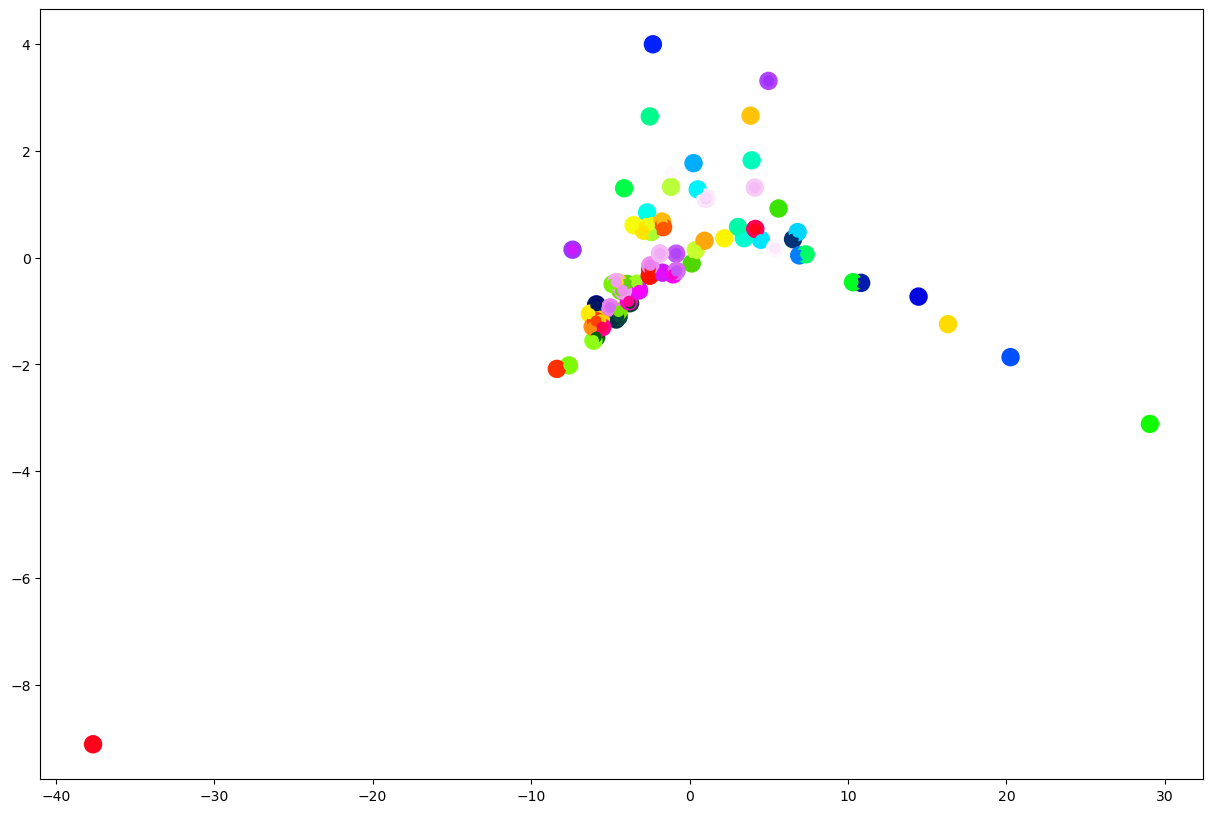

In [101]:
plt.figure(figsize=(15,10))
x_cent = embedding.transform(centroids2)[list(set([a for a, _, _, _  in taxon_list])),:]
plt.scatter(x_cent[:,0],x_cent[:,1], c=[a for a, _, _, _  in taxon_list],cmap=plt.cm.get_cmap('gist_ncar', 79), s=150) # cubehelix
plt.scatter(X_transformed[:,0],X_transformed[:,1], c=[a for a, _, _, _  in taxon_list],cmap=plt.cm.get_cmap('gist_ncar', 79),s=50)

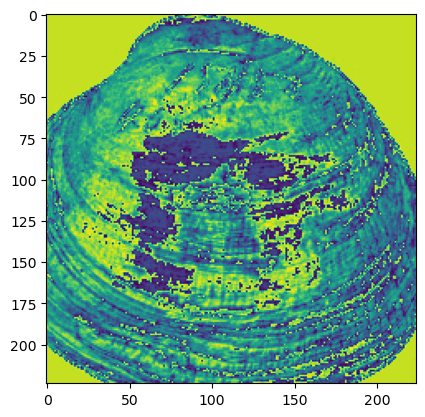

In [102]:

plt.imshow(torchvision.transforms.ToPILImage()(dataset[0][0][0]))
#plt.imshow(transforms.ToPILImage()(dataset[1][0][0]))

In [105]:
import pickle as pkl

In [106]:
figure_labels = np.stack(taxon_list)
ttl = [" <-> ".join(a.tolist()) for a in figure_labels[:,0:]]

In [109]:
_edge_lengths = torch.FloatTensor(edge_lengths.drop(columns='family').values)[true_label_locs][:,true_label_locs]
normed_edge_lengths = _edge_lengths/_edge_lengths.max()

In [112]:
import numpy as np

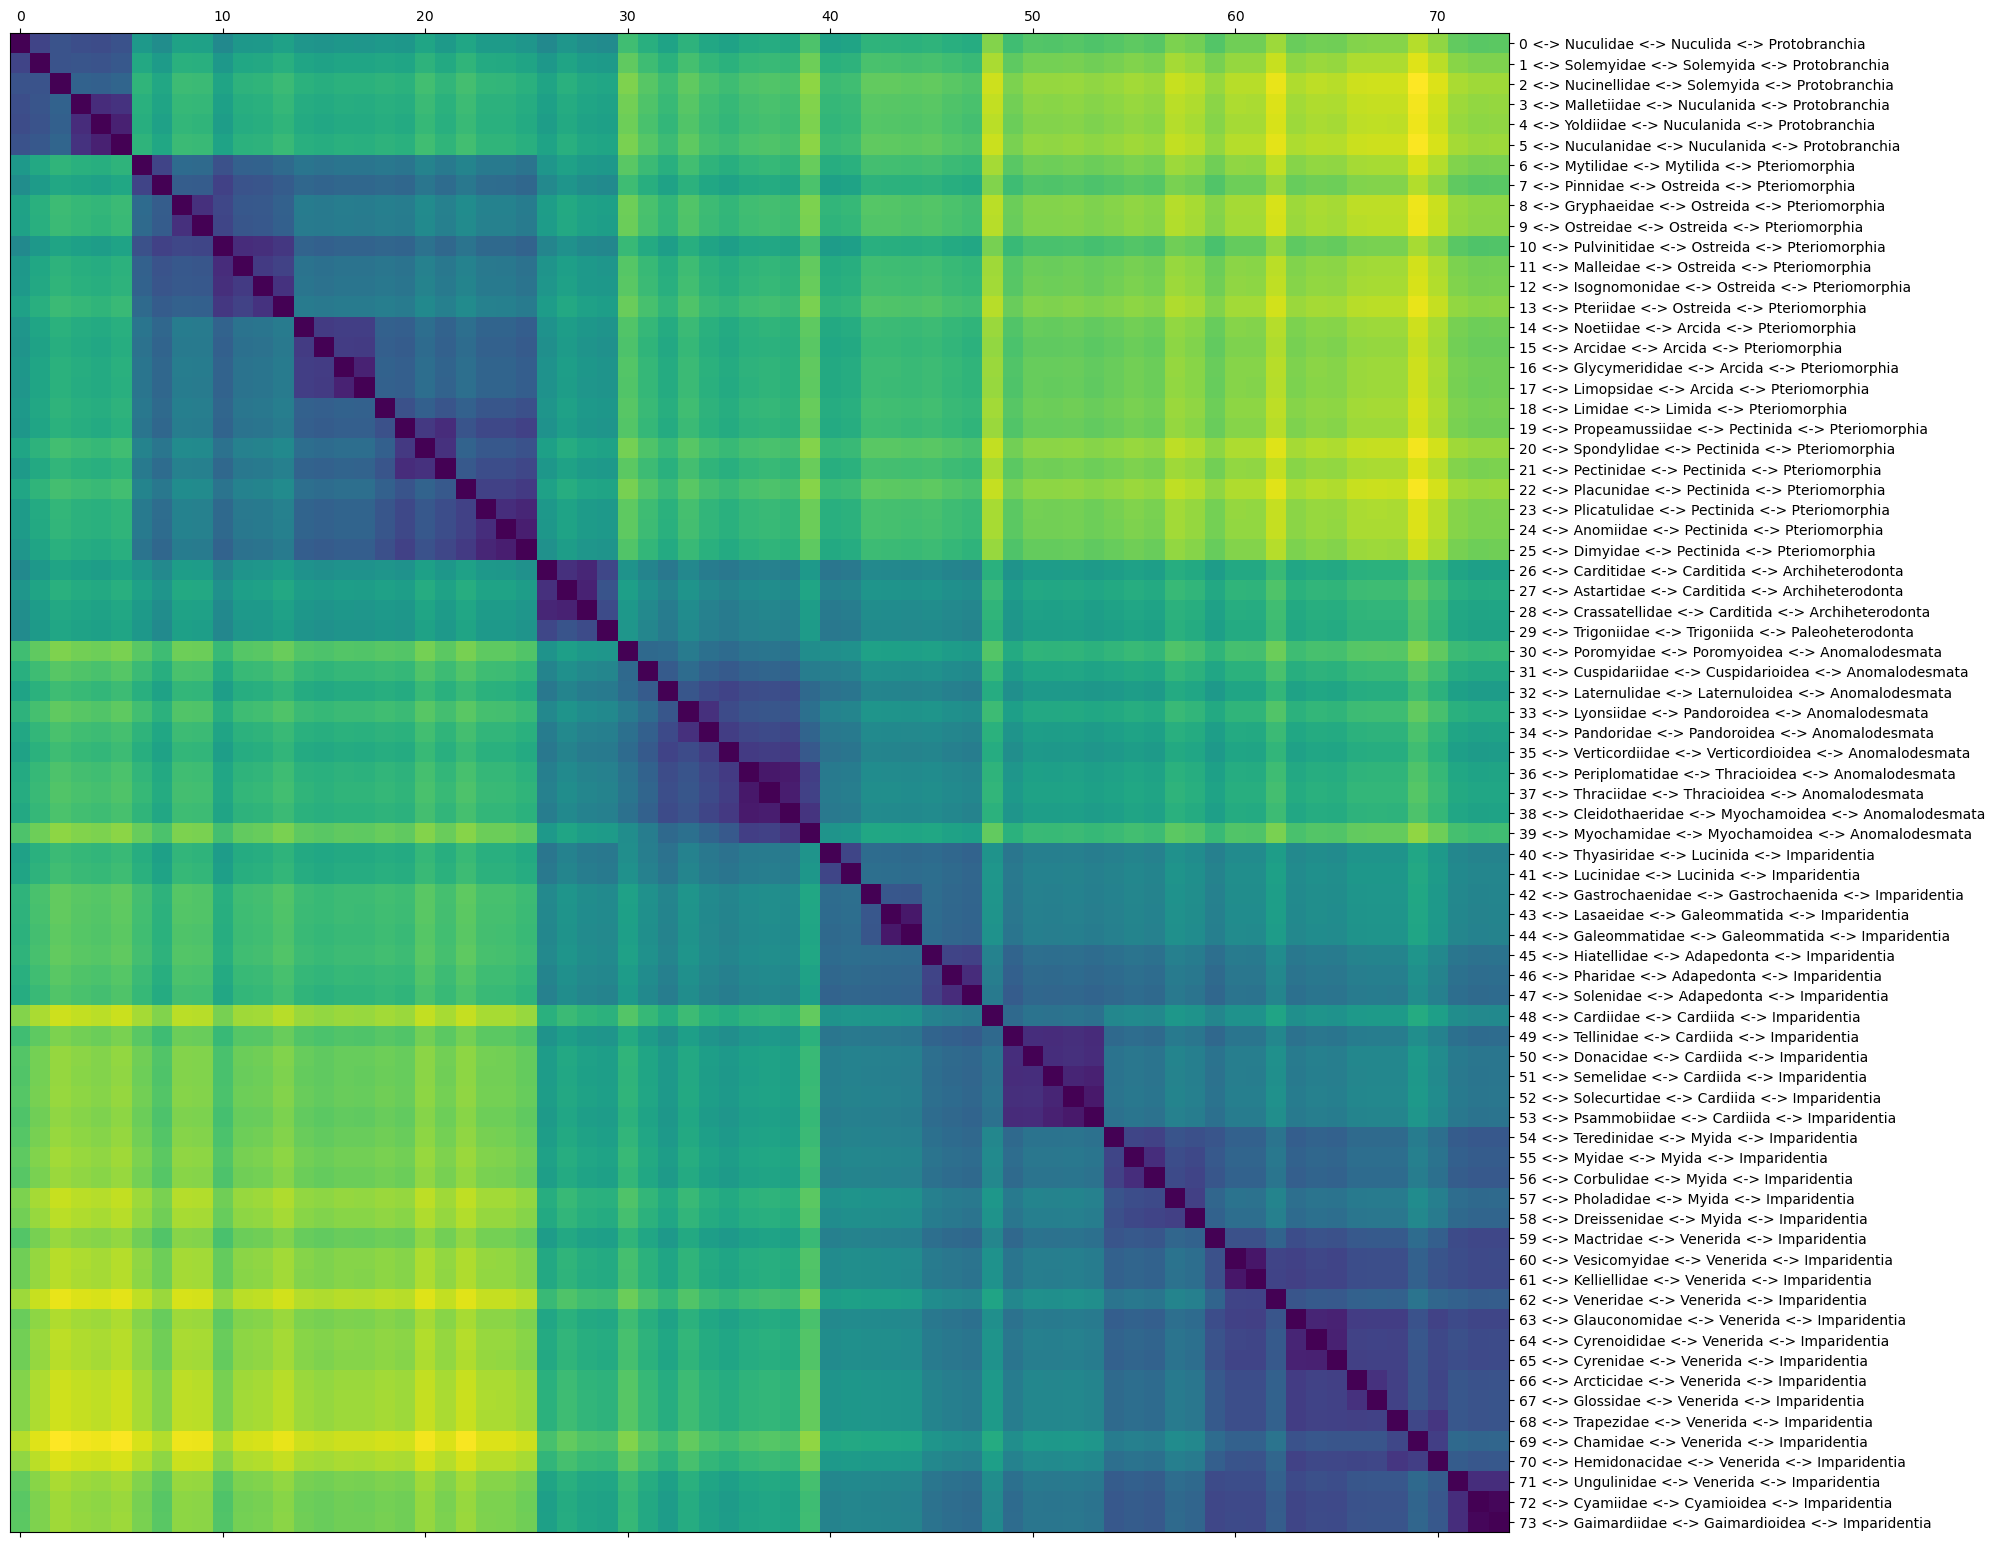

In [115]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()
ax.matshow(normed_edge_lengths)
ax.yaxis.tick_right()
ax.set_yticks(range(74))
#ax.set_yticklabels(figure_labels[:,1])
ax.set_yticklabels(ttl)
plt.tight_layout()
plt.savefig('lengths_v3.pdf')

tensor(1.)
tensor(1.) tensor(0.8706)


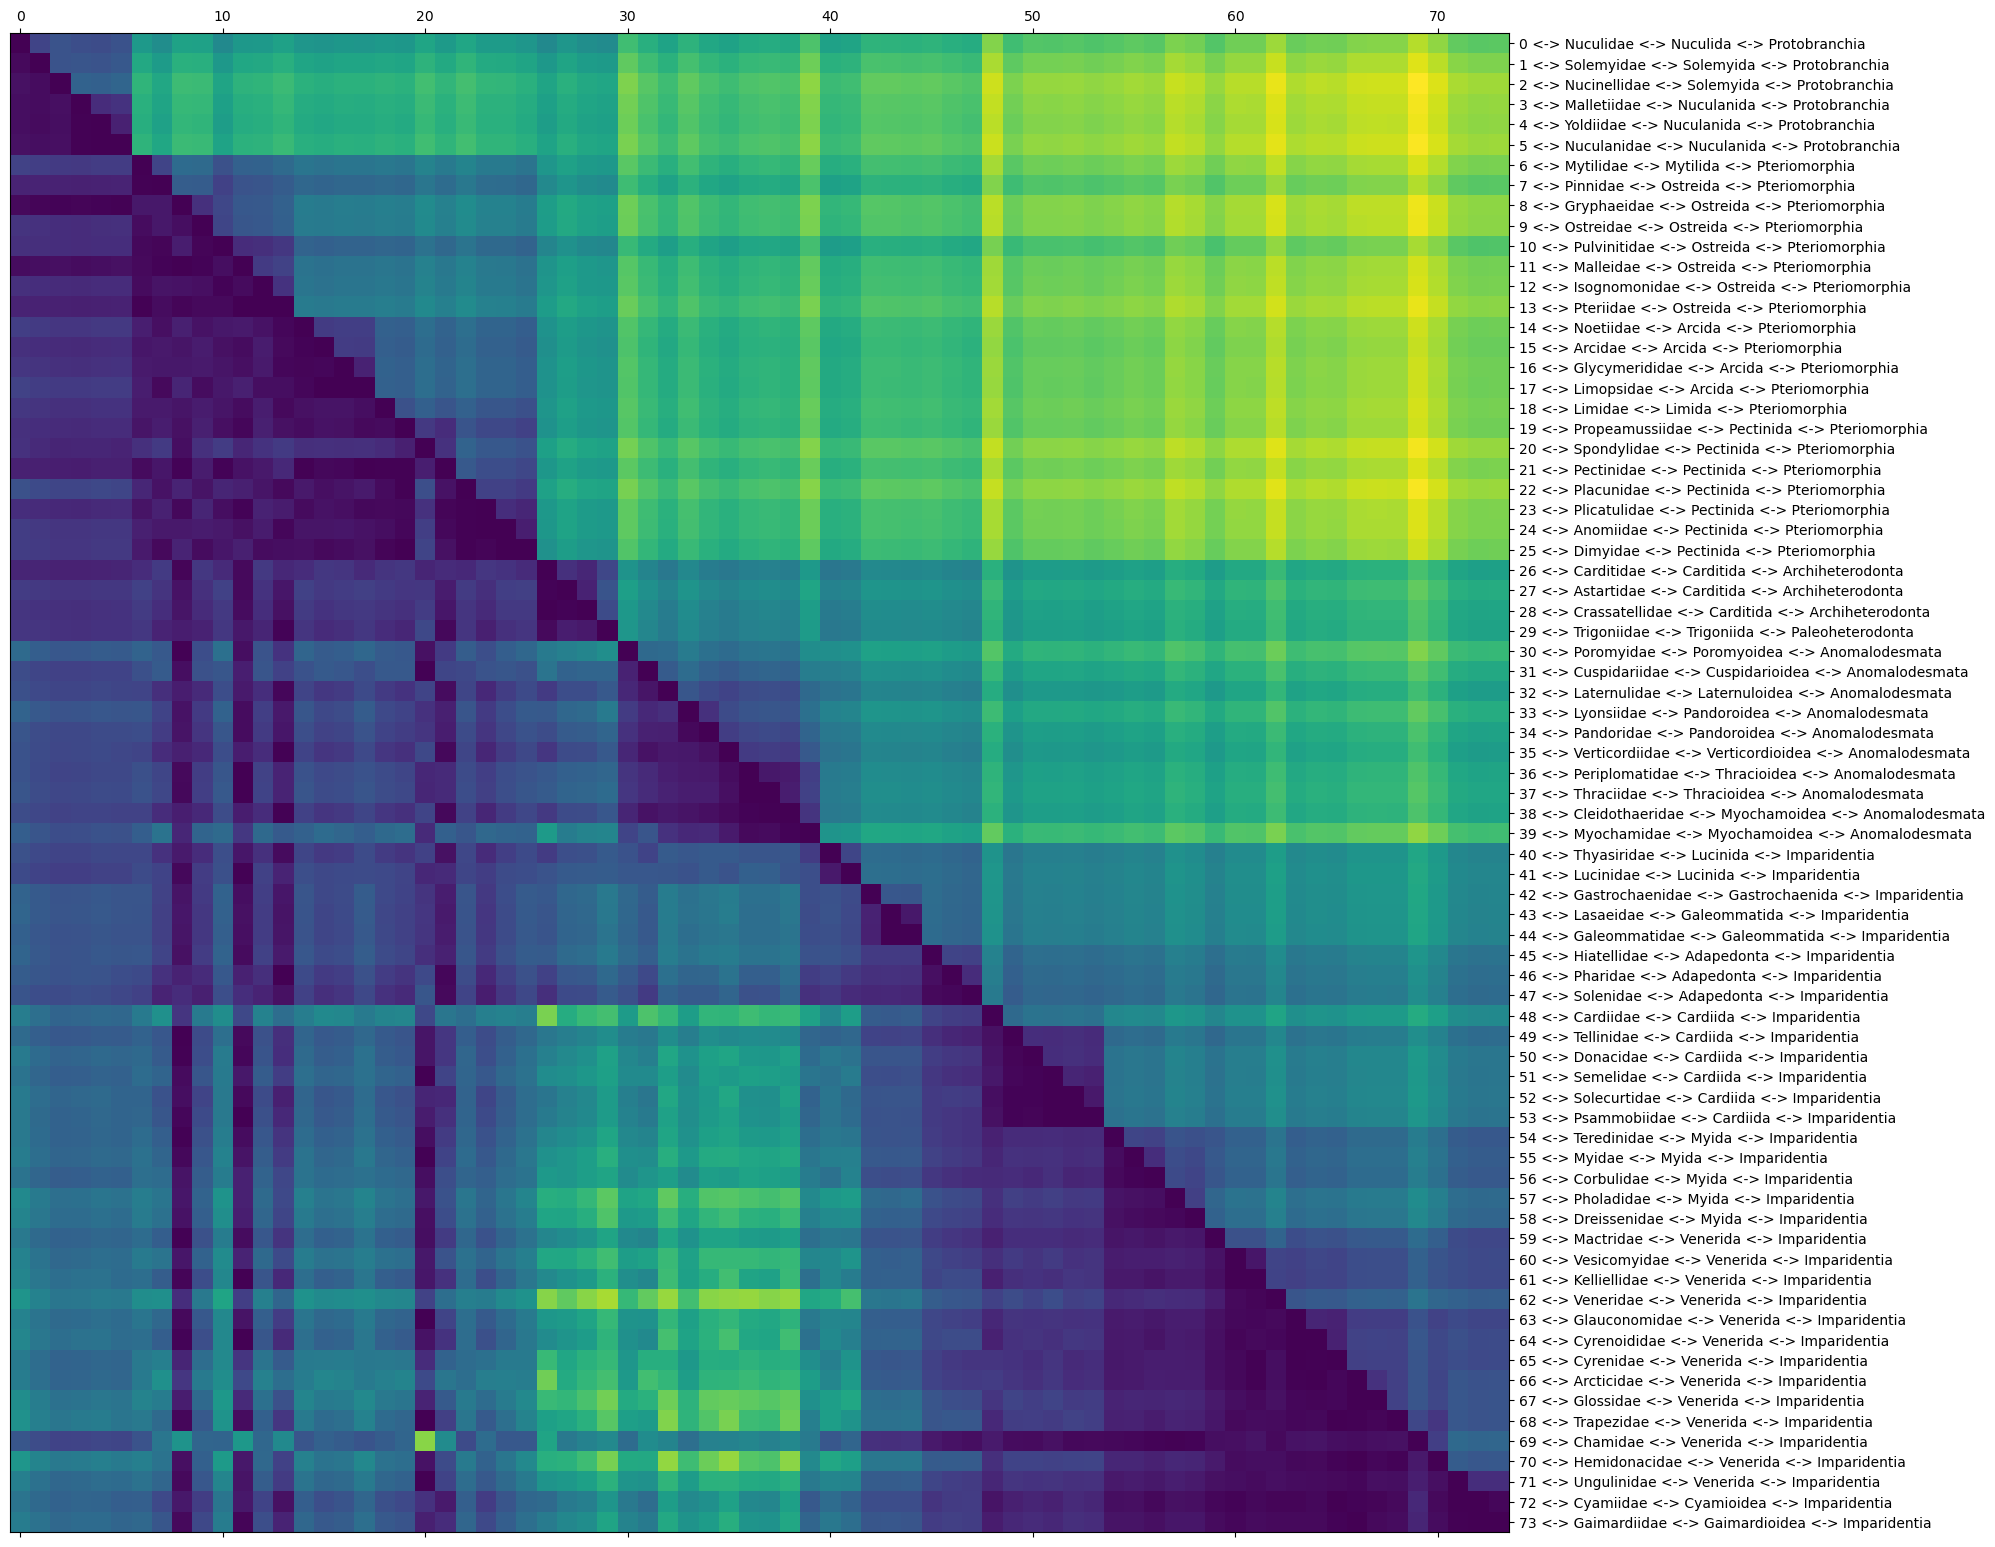

In [116]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()
#a = abs(((normed_edge_lengths / normed_edge_lengths.max(dim=1)[0]) / ( normed_distances /  normed_distances.max(axis=1)))*(normed_edge_lengths / normed_edge_lengths.max(dim=1)[0]))
_nlen = normed_edge_lengths / normed_edge_lengths.max(dim=1)[0]
_ndist = normed_distances /  normed_distances.max(axis=1)

a = abs(_nlen - _ndist) * _nlen

a[np.diag_indices(74)]=0
lower_half = a / a.max(dim=1)[0]

lower_half = lower_half - lower_half.min()
lower_half = lower_half / lower_half.max()

b = normed_edge_lengths.clone()# / normed_edge_lengths.max(dim=1)[0]
b = b / b.max()
upper_half = b
upper_half = upper_half - upper_half.min()
upper_half = upper_half / upper_half.max()

show_mat = np.ones_like(lower_half, dtype=np.float16)
upper_half[np.tril_indices(74)] = 0
lower_half[np.triu_indices(74)] = 0
ax.matshow(lower_half + upper_half)
#ax.matshow(lower_half**0.7 + upper_half)
ax.yaxis.tick_right()
ax.set_yticks(range(74))
#ax.set_yticklabels(figure_labels[:,1])
ax.set_yticklabels(ttl)
plt.tight_layout()

plt.savefig('lengths_correlation_tst_v3.pdf')

In [ ]:
import numpy as np
from scipy import stats

In [118]:
y = lower_half[np.array(np.arange(73,-1,-1)),:]
l2 = y[:,np.array(np.arange(73,-1,-1))]

In [120]:
def get_stats(a,b):
    res = stats.pearsonr(a[a>=0],b[b>=0])
    return res

# Calculate Pearson correlation over all 

In [121]:
l1, l2 = upper_half.clone(), lower_half.T.clone()
get_stats(l1,l2)

(0.7757987476275265, 0.0)

In [123]:
taxonTree = pd.DataFrame(taxon_list, columns=["Idx","Family",'Order',"Subclass"])

# Calculate Pearson correlation on subclasses

In [124]:
for subclass in set(taxonTree.Subclass):
    idxs = taxonTree[taxonTree.Subclass==subclass].Idx.values
    
    print(subclass, get_stats(l1[idxs],l2[idxs]))

Archiheterodonta (0.636577831452658, 1.2642899216729104e-26)
Protobranchia (-0.059530099583046475, 0.2105875305923321)
Pteriomorphia (0.4231803273737482, 2.2743942181896002e-65)
Imparidentia (0.5588049726314075, 1.2417115390810448e-206)
Paleoheterodonta (0.5775546986303348, 7.150040625538921e-08)
Anomalodesmata (0.5966446323490414, 1.4916151648154014e-72)


# Calculate Pearson correlation on Orders

In [ ]:
for order in set(taxonTree.Order):
    idxs = taxonTree[taxonTree.Order==order].Idx.values
    print(idxs)
    if len(l1[idxs]) <3:
        print(f"Skipping {order}")
        continue
    print(order, get_stats(l1[idxs],l2[idxs]))

[30]
Skipping Poromyoidea
[54 55 56 57 58]
Myida (0.5982063217980025, 2.7848527366779417e-37)
[31]
Skipping Cuspidarioidea
[0]
Skipping Nuculida
[40 41]
Skipping Lucinida
[38 39]
Skipping Myochamoidea
[45 46 47]
Adapedonta (0.6111603044849334, 3.9892045567196034e-24)
[29]
Skipping Trigoniida
[26 27 28]
Carditida (0.636577831452658, 1.2642899216729104e-26)
[42]
Skipping Gastrochaenida
[35]
Skipping Verticordioidea
[72]
Skipping Cyamioidea
[43 44]
Skipping Galeommatida
[3 4 5]
Nuculanida (-0.034718556867507945, 0.6068816765033599)
[33 34]
Skipping Pandoroidea
[6]
Skipping Mytilida
[19 20 21 22 23 24 25]
Pectinida (0.47378613457662827, 2.4150986858194896e-30)
[ 7  8  9 10 11 12 13]
Ostreida (0.5046490628063625, 8.050685263046216e-35)
[1 2]
Skipping Solemyida
[48 49 50 51 52 53]
Cardiida (0.599365693672204, 1.200494690818932e-44)
[18]
Skipping Limida
[73]
Skipping Gaimardioidea
[32]
Skipping Laternuloidea
[59 60 61 62 63 64 65 66 67 68 69 70 71]
Venerida (0.6605790170146816, 1.173105641218